# <center><font size=10>人脸识别</font></center>



# <span id='content'>目录</span>

## [一、课前回顾](#一)

## [二、卷积神经网络之应用--人脸识别](#二)

### [- 1. 人脸识别简介](#二-1)

### [- 2. 人脸识别两大问题：人脸认证、人脸识别](#二-2)

### [- 3. 进行人脸认证的一种简单思路](#二-3)

### [- 4. 使用卷积神经网络进行人脸认证的流程概括](#二-4)

## [三、人脸识别流程详细说明](#三)

### [- 1. 迁移学习](#三-1)

### [- 2. 举例：用VGG16模型进行编码](#三-2)

### [- 3. LFW数据库](#三-3)

### [- 4. 通过比对两张图片的编码进行人脸认证](#三-4)

### [- 5. 阈值的确定](#三-5)

### [- 6. 三元组代价函数--一种在人脸识别领域应用广泛且有效的损失函数](#三-6)

### [- 7. MTCNN](#三-7)

## [四、大作业：班级人脸识别项目](#四)


# <span id='一'>一、课前回顾</span>

上一课中，我们已经开始用卷积神经网络进行图片分类，已经了解了如下知识点：

- convolution：相关概念filter, padding, channel
- batch normalization 批规范化：通过对每一层的输出规范为均值和方差一致的方法，消除了w带来的放大缩小的影响。
- pooling: max vs. average
- 激活函数：softmax, Relu, Sigmoid

# <span id='二'>二、卷积神经网络之应用--人脸识别</span>

卷积神经网络最重要的应用之一是人脸识别，这一课我们就用卷积神经网络来处理人脸图片。


## <span id='二-1'>1. 人脸识别简介</span>
- 定义：
 - 广义的人脸识别实际包括构建人脸识别系统的一系列相关技术，包括人脸图像采集、人脸定位或检测、人脸识别预处理、身份确认以及身份查找等；
 - 而狭义的人脸识别特指通过人脸进行身份确认或者身份查找的技术或系统。
- 人脸识别的一般处理流程：
 - 图像获取：人脸图像通过摄像镜头获取得到；
 - 人脸检测：在图像中标定出人脸的位置和大小，自动估计脸部特征的坐标；
 - 人脸图像预处理：由于原始图像往往受到光照、角度等条件的限制和干扰，故须在图像处理的早期阶段对其进行灰度矫正、噪声过滤等预处理。
   - 常用预处理方法有 ：灰度变化、归一化、直方图均衡、中值滤波等；
 - 人脸特征提取：可通过嵌入向量的方法提取出有助于人脸分类的特征数据；
 - 比对识别：两张人脸图片经一系列操作后可进行对比识别；
 - 输出结果：判断两张人脸图片是否属于同一人。
 
  如下图所示：

<img style = "float:left" src = "辅助图片/人脸识别流程.jpg">

## <span id='二-2'>2. 人脸识别两大问题：人脸认证、人脸识别</span>

#### (1). 人脸识别：
首先拥有多人图像数据库，然后输入一张不在数据库中的人脸图像，目标是判断此人是否在数据库中，是的话并找到对应的那个人。是1：N问题。

注：人脸认证和人脸识别也可统称为人脸识别，本课在不混淆意思的前提下会统称为人脸识别。

#### (2). 人脸认证：
输入人脸图像，并指定数据库中要比对的人，目标是判断两张人脸图像是否属于同一个人，是1：1问题。


#### (3). 二者对比：
|  |  人脸认证   | 人脸识别  |
| :----  |  :----  | :----  |
| 输出  | 认证的信心度  | 最相似的人脸以及信心度 |
| 实现要求  |    在手机配置上就可以实现得很好  | 对于计算和存储的要求更高 |
| 成功要求  | 很低的false positive  | 很低的false positive和false negative |



就二者的难度来说，人脸识别要比人脸认证难得多：

假设一个认证系统的准确率是99%，把这个认证系统应用到有100个人数据库的人脸识别上，犯错的机会就会乘以100。所以如果有一个上百人的数据库，并且想得到一个可接受的人脸识别误差，首先构造的人脸认证系统就需要99.9%，甚至更高的准确率才行。

我们可以考虑首先构造一个人脸认证系统作为基本模块，进行处理之后，再把它应用到人脸识别系统上。


## <span id='二-3'>3. 进行人脸认证的一种简单思路</span>
对于人脸认证，最简单的思路是：
拿到两张人脸图像，直接比较两张图像中所有像素值的差别，取其加和。若该值小于事先确定的阈值，则可以认为他们是同一个人。

>思考：这样做会存在什么问题吗？

答：比对过程会受到非人脸部分的影响，即色彩、亮度、环境等都会使两张的图像的像素值之差不准确。例如，同一个人的照片加个滤镜可能就认不出来了。同时，同一个人不同角度的图片也会在像素值上有天翻地覆的差别，从而影响结果。

>思考：那么能否从图像中剔除这些影响，只找到与人脸外形相关的特征，然后进行比对？

答：对于受到非人脸环境的影响问题，可参照人脸识别处理流程中的预处理步骤，对图片进行预处理；而对于同人不同角度等问题造成的识别精度不够这种情况，则提醒我们要寻求一个更精准识别人脸的方法。

也就是本课的主题：运用卷积神经网络识别人脸。

## <span id='二-4'>4. 使用卷积神经网络进行人脸认证的流程概括</span>

卷积神经网络分别以两张图片作为输入，然后输出这两张图片的编码（即特征向量）。如果你放进同一个人的两张照片，你希望最后输出的两个编码之间的距离很小，如果放进两个长相差别很大的人的照片，就希望距离很大。

所以在人脸认证过程中，需要人为确定一个阈值。如果这两张图片的距离小于某个阈值，那么这时就能预测这两张图片是同一个人，如果距离大于阈值，就能预测这是不同的两个人。

***
>现在让我们开始我们的人脸识别之旅吧！

首先导入本课程所需要的库以及运行所需要的各项准备：
***

In [1]:
import os
import torchvision.models as models
from PIL import Image, ImageDraw
import datetime
from torch.autograd import Variable
import torch
import cv2
import numpy as np
from facenet_pytorch import MTCNN, extract_face
import matplotlib.pyplot as plt
device = 'cpu'

### <span id='三'>三、人脸识别流程详细说明</span>

>首先，我们学习如何将人脸图片进行编码。

卷积神经网络（CNN）常用来为人脸图片编码。例如，VGG就是这样一个为图像编码的CNN模型，其效果如下图所示：

<img src = "辅助图片/VGG编码.jpg">


>人脸图片的编码完成后，我们会利用编码来完成一系列功能。这是一个迁移学习过程。

## <span id='三-1'>1. 迁移学习</span>
>吴恩达：“迁移学习将会是继监督学习之后的下一个机器学习商业成功的驱动力。”

- 出现背景：
 - 目前的深度学习只有在拥有充足的标注数据时才能达到很好的准确率。
 - 海量数据下的模型训练需要非常大的算力。普通人：臣妾做不到啊~

- 思想：将旧领域的模型应用在新领域上，从而加快并优化模型的学习效率。

- 具体做法：利用在大数据集上预先训练好的神经网络来初始化网络（而不是随机初始化），然后根据自己的目标任务需求，可选择通过微调等操作对这个神经网络的结构进行改动，并在自己的数据集上进行进一步的训练。

- 核心问题：
 - 如何合理地寻找不同领域之间的相似性，从而利用相似性，将已有模型应用到新的不同的、但有一定关联的领域中。
 - 如何对使用的预训练模型进行适用于自己目标任务的改动。

- 例如：
  在自然语言处理领域中，预训练模型BERT的语义表达效果非常好。输入一句话，BERT可以生成这句话的嵌入向量（即用数字向量的形式来表达这句话），距离相近的向量对应的原句的意思也是相近的。我们在BERT模型的基础上，给这个神经网络再加上一个头部，如加上全连接层来作为分类器，就可以把输入的文本做分类，从而应用到如情感分析等具体任务上。


本课我们使用VGG16模型为例，展示一下图片的编码结果。鼓励同学们在进行大作业的编写时，通过查找和对比效果来选择其他效果更好的模型，并可选择结合迁移学习知识，使模型效果更佳。

## <span id='三-2'>2. 举例：用VGG16模型进行编码</span>

#### 选取两张图片，进行大小调整，使其符合VGG16模型的输入要求

In [3]:
# 为了能够读写带中文路径的图片，重新定义cv2的读写函数
def cv2_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), -1)
    return cv_img


def cv2_imwrite(path, img):
    cv2.imencode('.jpg', img)[1].tofile(path)

img1 = cv2_imread("李小强.jpg")
new_img1 = cv2.resize(img1, (224, 224))
cv2_imwrite("preprocessed李小强.jpg", new_img1)

img2 = cv2_imread("张小二.jpg")
new_img2 = cv2.resize(img2, (224, 224))
cv2_imwrite("preprocessed张小二.jpg", new_img2)

#### 将图片格式修改为可以直接输入模型的张量格式，然后调用训练好的VGG模型，输出图片通过模型前后的格式。

In [4]:
# 定义函数，将图片转成张量格式
def tensor_convert_vgg(img_path):
    img = cv2_imread(img_path)
    batch = img.reshape(1, 3, 224, 224)
    tensor = torch.from_numpy(batch).float().to(device)
    return tensor

img1_name = "preprocessed李小强.jpg"
img2_name = "preprocessed张小二.jpg"


tensor1 = tensor_convert_vgg("preprocessed李小强.jpg")
tensor2 = tensor_convert_vgg("preprocessed张小二.jpg")

vgg = models.vgg16(pretrained=True).eval().to(device)

result1 = vgg(Variable(tensor1))
result2 = vgg(Variable(tensor2))

print("李小强：\n", "  vgg16模型输入大小为: ", list(tensor1.size()),
      "; 输出大小为: ", list(result1.size()))
print("张小二：\n", "  vgg16模型输入大小为: ", list(tensor2.size()),
      "; 输出大小为: ", list(result2.size()))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\vgg16-397923af.pth


KeyboardInterrupt: 

若运行结果正确，我们可以看到，通过VGG模型前，两张图像的大小为\[1, 3, 224, 224]，分别对应\[样本数, 图像通道数, 图像高度, 图像宽度]。通过VGG模型后，两张图像变成了两个1000维的特征向量。

#### (4). 注意事项：
同学们在进行实验时，要先明确好自己选择的模型的输入是什么格式，以免出错。

>上述应用的两张图片都是从LFW数据集中选取的。

## <span id='三-3'>3. LFW数据库</span>

LFW (Labeled Faces in the Wild)人脸数据库主要用于研究非受限情况下的人脸识别问题。共含有13000多张人脸图像，其主要来源是互联网。每张图像都被标识出对应的人的名字，大约其中的1680人包含两个以上的人脸。

LFW数据库可用于测试人脸识别的准确率，该数据库随机选择了6000对人脸组成了人脸辨识图片对，其中3000对属于同一人，3000对属于不同的人。测试过程中，LFW数据库随机给出一对图片，询问测试中的系统这两张图片是不是同一个人，系统给出“是”或“否”的答案。通过6000对人脸测试结果的系统答案与真实答案的比值，可以得到系统的人脸识别准确率。

[LFW数据库传送门](http://vis-www.cs.umass.edu/lfw/)
***
>现在我们的第一步已经完成，即已经将图像编好码了。接下来就是要对比两张图片。

## <span id='三-4'>4. 通过比对两张图片的编码进行人脸认证</span>

**实际上，对比两张图片就是要对比图片对应的编码向量的距离（如欧几里得距离），如下图所示。**

<img src = "辅助图片/两人距离.jpg">

>进行人脸认证时，要确定两张图片是否是同一张人脸，需要事先确定一个阈值，当两张图片的距离小于阈值时，模型认为图片是同一张人脸；当距离大于阈值时，认为是不同的人脸。那么，阈值该如何确定呢？

## <span id='三-5'>5. 阈值的确定</span>
加上阈值后，整个人脸识别流程如下图所示：

<img style = "float:left" src = "辅助图片/两人距离有阈值.jpg">

对于阈值的确定没有数学上的计算方法，而通常是通过尝试，根据经验选择。在确定阈值的过程中，往往要事先确定好一个范围，并通过不断地在多个图像组上的测试，来缩小这个范围，最终在错误率最低的那个范围中选取一个值作为最终的阈值。

***


## <span id='三-6'>6. 三元组代价函数--一种在人脸识别领域应用广泛且有效的损失函数</span>

我们本课直接使用了VGG16预训练模型做例，但是用户可以根据自己的需求进行模型选择或者在原模型基础上进行改进。比如在训练过程中，我们可以改为在人脸识别领域效果更好的三元组代价函数（Triplet Loss），然后再通过梯度下降来更新网络中的权重。

#### (1). 三元组是什么：
- 样本组成：三张图片：
 - 靶目标(Anchor)，简写为 $A$.
 - 正例(Positive)，简写为 $P$.
 - 反例(Negative)，简写为 $N$.
- 样本要求：靶目标和正例是同一个人，和反例不是同一个人。
- 目的：在定义了这些包括$A、P、N$图片的数据集后，用梯度下降最小化代价函数，使得$A$和$P$之间的距离很小，而$A$和$N$之间的距离很大。
- 效果：通过改变神经网络中的权重，最终得到一个优秀的特征向量，使得相似的图像在向量空间是相近的，可以借此判断是否是同一个人的人脸。

三元组代价函数的效果图如下：

<img style = "float:left" src = "辅助图片/三元代价函数效果图.jpg">

#### (2). 三元组代价函数（Triplet Loss）的推导：
设图片A的编码为$f(A)$，图片P的编码是$f(P)$，图片N的编码是$f(N)$，我们希望靶目标A和正例图片P的间距小于靶目标和反例图片N的间距，即：

$$\|f(A)-f(P)\|^{2} \leq\|f(A)-f(N)\|^{2}$$

$$\|f(A)-f(P)\|^{2}-\|f(A)-F(N)\|^{2} \leq 0$$

但是这样还不够，比如当 $d(A,P)=0.5$, $d(A,N)=0.51$ 的时候，虽然满足了要求，但是二者之间的距离差很小，这样训练得到的结果不能很好地区分相似的图像，因此为了增强算法的鲁棒性，我们引入一个超参数 $\alpha$，将上述不等式修改为：

$$\|f(A)-f(P)\|^{2}-\|f(A)-f(N)\|^{2} \leq-\alpha$$

$$\|f(A)-f(P)\|^{2}-\|f(A)-F(N)\|^{2}+\alpha \leq 0$$

超参数 $\alpha$ 类似于支持向量机中的margin，目的就是要拼命拉近靶目标和正例之间的距离、拉远靶目标和反例之间的距离。

同时，$\alpha$ 值的选取也是一门学问：过小的话会将所有图像映射到极小区域范围内的向量空间，不能很好地区分；过大的话loss值会很难趋近于零，训练时间会无限延长。

***
综上，三元组代价函数是基于上述三元图片组的，定义为：

$$L(A, P, N)=\max \left(\|f(A)-f(P)\|^{2}-\|f(A)-f(N)\|^{2}+\alpha, 0\right)$$

在代价函数中，取两项中的最大值，我们要尽可能的使 $\|f(A)-f(P)\|^{2}-\|f(A)-f(N)\|^{2}+\alpha$ 这一项为0，或者小于0，这样这组三元组得到的代价值就为0；如果前一项大于0，得到的代价值就会大于0.

整个网络的代价函数就是训练集中每个三元组代价的总和，若共有M个三元组，则整个网络的三元代价函数为：

$$J=\sum_{i=1}^{M} L\left(A^{(i)}, P^{(i)}, N^{(i)}\right)$$

#### (3). 如何选择三元组来构成训练集？

你可能觉得，随机选择是最好的方法。但是实际上，这样的话约束条件 $d(A, P)+\alpha \leq d(A, N)$ 就会很容易实现。因为随机选择的图片，$A$ 和 $N$ 比 $A$ 和 $P$ 差别很大的概率不算小，这样的话网络并不能从中学习到什么。

所以，为了构建一个更有效的数据集，要做的就是尽可能选择难训练的三元组 $A$、 $P$ 和 $N$。 即要想使得所有三元组都满足条件
$d(A, P)+a \leq d(A, N)$ ，应选择最接近的 $d(A, P)$ 和 $d(A, N)$，这样学习算法会竭尽全力使得 $d(A, N)$ 变大，或者使得 $d(A, P)$ 
变小，这样选择可以增加学习算法的计算效率。


>以上代码全是根据数据集中的照片进行操作的，如果提供日常中拍出的照片，进行人脸识别，会出现什么问题呢？

## <span id='三-7'>7. MTCNN</span>

我们知道，数据集中的照片都是经过加工之后的，是专门用来训练或者测试模型的。但是日常拍照并非如此，普通照片中，人的身体和周围环境往往被照进镜头从而导致人脸识别误差增大。

此时，我们需要进行一系列操作，使得机器能够自动截取照片上的人脸，然后再送去编码识别。

**MTCNN就是干这个的。**

MTCNN（多任务卷积神经网络）中的"MT"是指多任务学习(Multi-Task)，同时学习“识别人脸”、“人脸边框回归”、“人脸关键点识别”；"CNN"是指卷积神经网络(Convolutional Neural Network)。MTCNN是由中国科学院提出的用于人脸检测任务的多任务神经网络模型，可进行快速高效的人脸检测。

我们来尝试使用MTCNN，看看它的作用效果。

In [4]:
mtcnn = MTCNN(keep_all=True)
img = Image.open("test1.jpg")
boxes, probs, points = mtcnn.detect(img, landmarks=True)
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
    draw.rectangle(box.tolist(), width=5)
    for p in point:
        draw.rectangle((p-10).tolist()+(p+10).tolist(), width=10)
    extract_face(img, box, save_path='detect_face_{}.png'.format(i))
img_draw.save('annotated_faces.png')

上面这个代码块使用同级目录下的名为"test1.jpg"的图片作为输入，将经过MTCNN人脸关键点标注后的结果进行可视化之后命名为"annotated_face.png"，保存在同级目录下，将MTCNN的截取结果命名为"detect_face_0.png"，保存在同级目录下。下面进行这三张图片的展示。

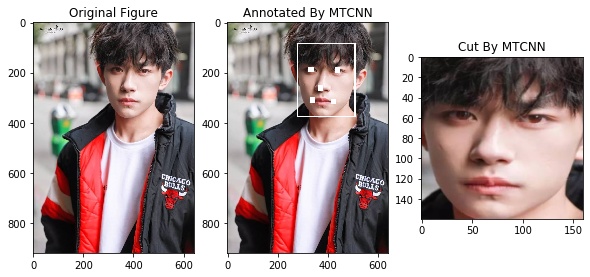

In [5]:
plt.figure()
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.4, top=0.9,
                wspace=0.2, hspace=0.2)
img = Image.open("test1.jpg")
ax = plt.subplot(1,3,1)
plt.imshow(img)
ax.set_title("Original Figure")

img = Image.open("annotated_faces.png")
ax = plt.subplot(1,3,2)
plt.imshow(img)
ax.set_title("Annotated By MTCNN")

img = Image.open("detect_face_0.png")
ax = plt.subplot(1,3,3)
plt.imshow(img)
ax.set_title("Cut By MTCNN")

plt.show()

由上图我们可以看到，MTCNN可以识别一张图片中的人脸位置所在，同时定位到人脸关键点，包括眼、鼻、嘴。所以使用通过MTCNN截取后的人脸图片，我们可以使人脸识别不再受照片中环境等因素的影响，使得识别精度更高。

有感兴趣的同学可以去[这里](https://blog.csdn.net/qq_36782182/article/details/83624357?depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1&utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1)看一下MTCNN的具体架构和工作原理，此处不再多讲。

>现在我们已经基本掌握了人脸识别和认所需的模型运用等知识，下面来进行大作业的编写吧！

### <span id='四'>四、大作业：班级人脸识别项目</span>

满足条件及注意事项：
- 将所给人脸照片文件夹作为班级人脸数据库，其中每人有五张图片。
- test文件下存储的是用来识别或认证的不属于数据库中的照片，每人有一张图片。
- 将人脸识别的代码封装成一个函数，命名为facial_recognition，其输入是当前测试图片的路径，且函数要返回最相似的人的名字。
- 将人脸认证的代码封装成一个函数，命名为facial_verification，其输入是数据库中想要比对的人脸id和当前的测试图片的路径，且函数要根据认证的结果，即返回字符串“True”或字符串“False”。
- 定义人名列表，列表中每个元素是人名字符串（即类似于["张三", "李四"]），列表名为names，评测中用到的id值即为在names列表中的序号（从0开始）。
- 最终考核结果标准是识别的准确率和时间，以及认证的四项标准。

In [1]:
#################################START OF YOUR HOMEWORK#################################
import torch
import numpy as np
import pandas as pd
import math
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import optim
from facenet_pytorch import prewhiten
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from facenet_pytorch import InceptionResnetV1,training, MTCNN, fixed_image_standardization
import os
import cv2
from torch.autograd import Variable
from PIL import Image, ImageDraw
import sys
workers = 0 if os.name == 'nt' else 8
device = 'cpu'

In [2]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [2]:
#定义mtcnn
mtCNN = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
dataset = datasets.ImageFolder('mydata_可切割图片',transform=transforms.Resize((1024, 1024)))
dataset.samples = [(p, p.replace('mydata_可切割图片', 'mydata_cut'))
        for p, _ in dataset.samples]        
loader = DataLoader(dataset,num_workers=workers,
                    batch_size = 32,collate_fn=training.collate_pil)


# 对数据库图片进行mtcnn处理并保存
for i, (x, y) in enumerate(loader):
    mtCNN(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='') 

Batch 2 of 8

C:\Users\Lenovo\Desktop\58119213徐丹颖_人脸识别\无答案\facenet_pytorch\models\utils\detect_face.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\Lenovo\Desktop\58119213徐丹颖_人脸识别\无答案\facenet_pytorch\models\mtcnn.py:369: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
C:\Users\Lenovo\Desktop\58119213徐丹颖_人脸识别\无答案\facenet_pytorch\models\mtcnn.py:370: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists

Batch 8 of 8

In [ ]:
######################
#以上是数据集预处理
######################

In [44]:
data_dir = 'data'
batch_size = 25 
epochs = 8
device = torch.device( 'cpu')

In [45]:
resnet = InceptionResnetV1(
     classify=True,
     pretrained='vggface2',
     dropout_prob=0.8,
     num_classes=41,#班里有41位同学
).to(device)

In [46]:
#初始化模型后存为myresnet1.pt
torch.save(resnet,"myresnet1.pt")

In [57]:
#用1训练mytrain
#在此基础上使用finetune用自己的训练集进一步对模型优化

resnet=torch.load("myresnet1.pt")

optimizer = optim.Adam(resnet.parameters(), lr=0.001) 
scheduler = MultiStepLR(optimizer, [5, 10])
trans = transforms.Compose([
    transforms.RandomRotation(10),       #随机旋转
    transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1),  #随机亮度对比度饱和度变换，增加图像数据量，防止过拟合
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder('mytrain_cut', transform=trans)
#############
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)
print(len(train_loader))
##########
loss_fn = torch.nn.CrossEntropyLoss()

metrics = {
    'acc': training.accuracy
}
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10


for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
writer.close()

torch.save(resnet,"myresnet8.pt")

9

Epoch 1/8
----------
Train |     1/9    | loss:    3.4753 | acc:    0.9600   

KeyboardInterrupt: 

In [ ]:
#mytest_cut 验证结果

In [30]:
#人脸识别识别函数与判断函数定义
from torch.autograd import Variable
from PIL import Image, ImageDraw
resnet=torch.load("myresnet_final_30.pt")
names=[]
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

for item in os.listdir('mydata_cut'):
    names.append(item[9:])

def facial_recognition(path):
    resnet.eval()
    img=Image.open(path)
    img_tensor=trans(img)
    img_tensor=Variable(img_tensor.unsqueeze(0))
    output=resnet(img_tensor)
    _, train_predicted = torch.max(output.data, 1)
    print(names[train_predicted.item()])
    return names[train_predicted.item()]



def facial_verification(id,path):
    print(names[id])
    if facial_recognition(path)==names[id]:
        return 'True'
    else:
        return 'False'
    


In [30]:
print(names)

['蔡雅清', '方玉杰', '彭英哲', '闫海玉', '李佳祥', '廖宏祖', '陈智宏', '顾海健', '何远洋', '吕喆行', '朱宇飞', '蒋卓洋', '李柏萱', '李凯新', '袁一啸', '温若尧', '司考', '牟俊奇', '欧阳雨彤', '苏彤彤', '沈小力', '徐丹颖', '耿青青', '杨捷', '刘幽远', '沈洋洋', '吴东昊', '白云浩', '谢志林', '朱婷婷', '曾晗', '朱启鹏', '张静涵', '秦巧琳', '马添毅', '余江伟', '李雨辰', '刘誉飞', '罗卓彦', '王兆阳', '王湘源']


In [56]:
# 人脸识别评测代码    
import datetime

starttime = datetime.datetime.now()
right = 0
wrong = 0

for item in os.listdir("mytest_cut"):
    test_path = "mytest_cut"+"\\" + item
    print(item)
    if facial_recognition(test_path) in item:
        right += 1
    else:
        wrong += 1

accuracy = right / (right+wrong)
endtime = datetime.datetime.now()

print("人脸识别的考察结果：")
print("人脸识别的准确率是:", accuracy)
print("整个人脸识别的运行时间是：", (endtime-starttime).seconds, "s")


何远洋_1.jpg
白云浩
余江伟_1.jpg
余江伟
刘幽远_1.jpg
刘幽远
刘誉飞_1.jpg
刘誉飞
司考_1.jpg
司考
吕喆行_1.jpg
罗卓彦
吴东昊_1.jpg
吴东昊
廖宏祖_1.jpg
沈小力
张静涵_1.jpg
张静涵
彭英哲_1.jpg
彭英哲
徐丹颖_1.jpg
徐丹颖
方玉杰_1.jpg
陈智宏
曾晗_1.jpg
曾晗
朱启鹏_1.jpg
朱启鹏
朱婷婷_1.jpg
朱婷婷
朱宇飞_1.jpg
朱宇飞
李佳祥_1.jpg
李佳祥
李凯新_1.jpg
李凯新
李柏萱_1.jpg
陈智宏
李雨辰_1.jpg
李雨辰
杨捷_1.JPG
欧阳雨彤
欧阳雨彤_1.jpg
欧阳雨彤
沈小力_1.jpg
沈小力
沈洋洋_1.jpg
牟俊奇
温若尧_1.JPG
温若尧
牟俊奇_1.jpg
沈洋洋
王兆阳_1.jpg
王兆阳
王湘源_1.jpg
王湘源
白云浩_1.jpg
刘幽远
秦巧琳_1.jpg
秦巧琳
罗卓彦_1.jpg
罗卓彦
耿青青_1.JPG
耿青青
苏彤彤_1.jpg
张静涵
蒋卓洋_1.jpg
陈智宏
蔡雅清_1.JPG
耿青青
袁一啸_1.jpg
杨捷
谢志林_1.jpg
谢志林
闫海玉_1.jpg
闫海玉
陈智宏_1.jpg
张静涵
顾海健_1.jpg
顾海健
马添毅_1.jpg
王湘源
人脸识别的考察结果：
人脸识别的准确率是: 0.6341463414634146
整个人脸识别的运行时间是： 4 s


In [74]:
# 人脸认证评测代码

tp = 0
tn = 0
fp = 0
fn = 0

for name in names:
    test_path = "mytest_cut/" + name + "_1.jpg"
    for id in range(len(names)):
        result = facial_verification(id, test_path)
        if name == names[id] and result == "True":
            tp +=1
        elif name == names[id] and result == "False":
            fn += 1
        elif name != names[id] and result == "False":
            tn += 1
        else:
            fp += 1

print("人脸认证的考察结果:")
print("精度:", tp/(tp+fp))
print("回归率:", tp/(tp+fn))
print("特异性:", tn/(tn+fp))
print("F1值:", 2*tp/(2*tp+fp+fn))


蔡雅清
蔡雅清
方玉杰
蔡雅清
彭英哲
蔡雅清
闫海玉
蔡雅清
李佳祥
蔡雅清
廖宏祖
蔡雅清
陈智宏
蔡雅清
顾海健
蔡雅清
何远洋
蔡雅清
吕喆行
蔡雅清
朱宇飞
蔡雅清
蒋卓洋
蔡雅清
李柏萱
蔡雅清
李凯新
蔡雅清
袁一啸
蔡雅清
温若尧
蔡雅清
司考
蔡雅清
牟俊奇
蔡雅清
欧阳雨彤
蔡雅清
苏彤彤
蔡雅清
沈小力
蔡雅清
徐丹颖
蔡雅清
耿青青
蔡雅清
杨捷
蔡雅清
刘幽远
蔡雅清
沈洋洋
蔡雅清
吴东昊
蔡雅清
白云浩
蔡雅清
谢志林
蔡雅清
朱婷婷
蔡雅清
曾晗
蔡雅清
朱启鹏
蔡雅清
张静涵
蔡雅清
秦巧琳
蔡雅清
马添毅
蔡雅清
余江伟
蔡雅清
李雨辰
蔡雅清
刘誉飞
蔡雅清
罗卓彦
蔡雅清
王兆阳
蔡雅清
王湘源
蔡雅清
蔡雅清
方玉杰
方玉杰
方玉杰
彭英哲
方玉杰
闫海玉
方玉杰
李佳祥
方玉杰
廖宏祖
方玉杰
陈智宏
方玉杰
顾海健
方玉杰
何远洋
方玉杰
吕喆行
方玉杰
朱宇飞
方玉杰
蒋卓洋
方玉杰
李柏萱
方玉杰
李凯新
方玉杰
袁一啸
方玉杰
温若尧
方玉杰
司考
方玉杰
牟俊奇
方玉杰
欧阳雨彤
方玉杰
苏彤彤
方玉杰
沈小力
方玉杰
徐丹颖
方玉杰
耿青青
方玉杰
杨捷
方玉杰
刘幽远
方玉杰
沈洋洋
方玉杰
吴东昊
方玉杰
白云浩
方玉杰
谢志林
方玉杰
朱婷婷
方玉杰
曾晗
方玉杰
朱启鹏
方玉杰
张静涵
方玉杰
秦巧琳
方玉杰
马添毅
方玉杰
余江伟
方玉杰
李雨辰
方玉杰
刘誉飞
方玉杰
罗卓彦
方玉杰
王兆阳
方玉杰
王湘源
方玉杰
蔡雅清
彭英哲
方玉杰
彭英哲
彭英哲
彭英哲
闫海玉
彭英哲
李佳祥
彭英哲
廖宏祖
彭英哲
陈智宏
彭英哲
顾海健
彭英哲
何远洋
彭英哲
吕喆行
彭英哲
朱宇飞
彭英哲
蒋卓洋
彭英哲
李柏萱
彭英哲
李凯新
彭英哲
袁一啸
彭英哲
温若尧
彭英哲
司考
彭英哲
牟俊奇
彭英哲
欧阳雨彤
彭英哲
苏彤彤
彭英哲
沈小力
彭英哲
徐丹颖
彭英哲
耿青青
彭英哲
杨捷
彭英哲
刘幽远
彭英哲
沈洋洋
彭英哲
吴东昊
彭英哲
白云浩
彭英哲
谢志林
彭英哲
朱婷婷
彭英哲
曾晗
彭英哲
朱启鹏
彭英哲
张静涵
彭英哲
秦巧琳
彭英哲
马添毅
彭英哲
余江伟
彭英哲
李雨辰
彭英哲
刘誉飞
彭英哲
罗卓彦
彭英哲
王兆阳
彭英哲
王湘源
彭英哲
蔡雅清
闫海玉
方玉杰
闫海玉
彭英哲
闫海

沈洋洋
苏彤彤
沈洋洋
沈小力
沈洋洋
徐丹颖
沈洋洋
耿青青
沈洋洋
杨捷
沈洋洋
刘幽远
沈洋洋
沈洋洋
沈洋洋
吴东昊
沈洋洋
白云浩
沈洋洋
谢志林
沈洋洋
朱婷婷
沈洋洋
曾晗
沈洋洋
朱启鹏
沈洋洋
张静涵
沈洋洋
秦巧琳
沈洋洋
马添毅
沈洋洋
余江伟
沈洋洋
李雨辰
沈洋洋
刘誉飞
沈洋洋
罗卓彦
沈洋洋
王兆阳
沈洋洋
王湘源
沈洋洋
蔡雅清
吴东昊
方玉杰
吴东昊
彭英哲
吴东昊
闫海玉
吴东昊
李佳祥
吴东昊
廖宏祖
吴东昊
陈智宏
吴东昊
顾海健
吴东昊
何远洋
吴东昊
吕喆行
吴东昊
朱宇飞
吴东昊
蒋卓洋
吴东昊
李柏萱
吴东昊
李凯新
吴东昊
袁一啸
吴东昊
温若尧
吴东昊
司考
吴东昊
牟俊奇
吴东昊
欧阳雨彤
吴东昊
苏彤彤
吴东昊
沈小力
吴东昊
徐丹颖
吴东昊
耿青青
吴东昊
杨捷
吴东昊
刘幽远
吴东昊
沈洋洋
吴东昊
吴东昊
吴东昊
白云浩
吴东昊
谢志林
吴东昊
朱婷婷
吴东昊
曾晗
吴东昊
朱启鹏
吴东昊
张静涵
吴东昊
秦巧琳
吴东昊
马添毅
吴东昊
余江伟
吴东昊
李雨辰
吴东昊
刘誉飞
吴东昊
罗卓彦
吴东昊
王兆阳
吴东昊
王湘源
吴东昊
蔡雅清
白云浩
方玉杰
白云浩
彭英哲
白云浩
闫海玉
白云浩
李佳祥
白云浩
廖宏祖
白云浩
陈智宏
白云浩
顾海健
白云浩
何远洋
白云浩
吕喆行
白云浩
朱宇飞
白云浩
蒋卓洋
白云浩
李柏萱
白云浩
李凯新
白云浩
袁一啸
白云浩
温若尧
白云浩
司考
白云浩
牟俊奇
白云浩
欧阳雨彤
白云浩
苏彤彤
白云浩
沈小力
白云浩
徐丹颖
白云浩
耿青青
白云浩
杨捷
白云浩
刘幽远
白云浩
沈洋洋
白云浩
吴东昊
白云浩
白云浩
白云浩
谢志林
白云浩
朱婷婷
白云浩
曾晗
白云浩
朱启鹏
白云浩
张静涵
白云浩
秦巧琳
白云浩
马添毅
白云浩
余江伟
白云浩
李雨辰
白云浩
刘誉飞
白云浩
罗卓彦
白云浩
王兆阳
白云浩
王湘源
白云浩
蔡雅清
谢志林
方玉杰
谢志林
彭英哲
谢志林
闫海玉
谢志林
李佳祥
谢志林
廖宏祖
谢志林
陈智宏
谢志林
顾海健
谢志林
何远洋
谢志林
吕喆行
谢志林
朱宇飞
谢志林
蒋卓洋
谢志林
李柏萱
谢志林
李凯新
谢志林
袁一啸
谢志林
温若尧
谢志林
司考
谢志林
牟俊奇
谢志林
欧阳雨彤
谢志林
苏彤彤
谢志林
沈小力
谢志林
徐丹

In [31]:
#人脸识别识别函数与判断函数定义
from torch.autograd import Variable
from PIL import Image, ImageDraw
resnet=torch.load("myresnet_final.pt")
names=[]
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

for item in os.listdir('mydata_cut'):
    names.append(item[9:])

def facial_recognition(path):
    resnet.eval()
    img=Image.open(path)
    img_tensor=trans(img)
    img_tensor=Variable(img_tensor.unsqueeze(0))
    output=resnet(img_tensor)
    _, train_predicted = torch.max(output.data, 1)
    print(names[train_predicted.item()])
    return names[train_predicted.item()]



def facial_verification(id,path):
    print(names[id])
    if facial_recognition(path)==names[id]:
        return 'True'
    else:
        return 'False'
    

#一张照片的人脸识别
import sys

def cv2_imread(file_path):
    cv_img=cv2.imdecode(np.fromfile(file_path,dtype=np.uint8),-1)
    return cv_img

finaldir=input('请输入测试对象图片路径：')
#查看路径下是否有照片
yn=cv2_imread(finaldir)
if yn is None:
    print('该路径下没有图片！')
    sys.exit(0)
#如果有图片：
image=Image.open(finaldir)
mtCNN = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
mtCNN(image,finaldir)
#输出人脸识别结果
print(facial_recognition(finaldir))

请输入测试对象图片路径：q.jpg
秦巧琳
秦巧琳


In [6]:
#人脸识别识别函数与判断函数定义
from torch.autograd import Variable
from PIL import Image, ImageDraw
from facenet_pytorch import InceptionResnetV1,MTCNN, extract_face
import matplotlib.pyplot as plt

resnet=torch.load("myresnet5.pt")
names=[]
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

for item in os.listdir('mydata_cut'):
    names.append(item[9:])

mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device)

# 裁剪照片函数
def cut_images(path):
    img = Image.open(path)
    if img.mode == 'RGBA':
        r, g, b, a = img.split()
        img = Image.merge("RGB", (r, g, b))
        #print(names[i],j+1," 4 to 3")
    elif img.mode != 'RGB':
        img = img.convert('RGB')
        #print(names[i],j+1," 1 to 3")
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    paths=[]
    for i, (box, point) in enumerate(zip(boxes, points)):
        #给小图起名字
        path2=path[:-4]+str(i)+'.jpg'
        paths.append(path2)
        #保存小图
        extract_face(img, box, image_size=160,save_path=path2)
    return paths
    
    
def facial_recognition(path):
    resnet.eval()
    img=Image.open(path)
    img_tensor=trans(img)
    img_tensor=Variable(img_tensor.unsqueeze(0))
    output=resnet(img_tensor)
    _, train_predicted = torch.max(output.data, 1)
    print(names[train_predicted.item()])
    return names[train_predicted.item()]

threshold=0.9
def facial_recognition_for3(new_path):
    paths=cut_images(new_path)
    if len(paths)==0:
        print('Sadly, MTCNN can\'t find any person.')
        return
    img=[]
    for i,path in enumerate(paths):
        plt.figure(figsize=(5,5))
        #plt.subplots_adjust(left=0.125, bottom=0.1, right=1.4, top=len(paths), wspace=0.2, hspace=0.2)
        img.append(Image.open(path))
        #ax=plt.subplot(len(paths),1,i+1)
        plt.imshow(img[i])
        plt.show()
        yes=input("Is it the person you want to recognize?(y/n)")
        if yes=='y' or yes=='Y':
            facial_recognition_open(img[i])
        else:
            print("Let's see next one!")
    print("All done.")


def facial_verification(id,path):
    print(names[id])
    if facial_recognition(path)==names[id]:
        return 'True'
    else:
        return 'False'
    
# 以下为实时检测功能
import sys

# 为了能够读写带中文路径的图片，重新定义cv2的读写函数
def cv2_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), -1)
    return cv_img


def cv2_imwrite(path, img):
    cv2.imencode('.jpg', img)[1].tofile(path)
    
    

def mtcnn_cut(img_path, save_path):
    img = Image.open(img_path)
    # 应用MTCNN对图片进行检测截取，并保存到指定路径下。
    mtCNN = MTCNN(
        image_size=160, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=device
    )
    mtCNN(img, save_path=save_path)
       
    
def test_camera():
    cap = cv2.VideoCapture(0)
    while(1):
        ret, frame = cap.read()
        cv2.imshow("capture", frame)
        if cv2.waitKey(1) & 0xFF == ord('s'):
            cv2_imwrite("用户拍照上传图片.jpg", frame)
            break
    cap.release()
    cv2.destroyAllWindows()
    mtcnn_cut("用户拍照上传图片.jpg", "用户拍照上传图片.jpg")

choice = input("请输入想要的服务序号：A.人脸识别； B.人脸认证")

if choice == 'A' or choice == 'a':
    test_choice = input("请选择要测试的人脸图片获得途径: A.拍照； B.输入路径 C.多人检测")#
    if test_choice == 'A' or test_choice == 'a':
        test_camera()
        test_path = "用户拍照上传图片.jpg"
        print(facial_recognition(test_path))  # 进行人脸识别

    elif test_choice == 'B' or test_choice == 'b':
        test_path = input("请输入要测试的人脸图片路径：")

        # 测试该test_path下是否存在图片
        img = cv2_imread(test_path)
        if img is None:
            print("该路径下不存在图片！终止程序")
            sys.exit(0)

        mtcnn_cut(test_path, test_path)
        print(facial_recognition(test_path))  # 进行人脸识别
        
    elif test_choice == 'C' or test_choice == 'c':
        test_camera()
        

        mtcnn_cut(test_path, test_path)
        print(facial_recognition_for3(test_path))

    else:
        print("指令不存在！")
        sys.exit(0)


elif choice == 'B' or choice == 'b':
    test_choice = input("请选择要测试的人脸图片获得途径：A.拍照; B.输入路径")
    if test_choice == 'A' or test_choice == 'a':
        test_camera()
        test_path = "用户拍照上传图片.jpg"

    elif test_choice == 'B' or test_choice == 'b':
        test_path = input("请输入要测试的人脸路径：")
        # 测试该test_path下是否存在图片
        img = cv2_imread(test_path)
        if img is None:
            print("该路径下不存在图片！终止程序")
            sys.exit(0)
        mtcnn_cut(test_path, "test_mtcnn.jpg")  

    else:
        print("指令不存在！")
        sys.exit(0)

    # 便于用户提供想要测试的图片id号
    print("数据库中人脸图片及其序号为：")
    for i, name in enumerate(names):
        print(i, " ", name)

    id = input("请输入想要比对的人脸序号")
    print(facial_verification(int(id), test_path))  # 进行人脸认证

请输入想要的服务序号：A.人脸识别； B.人脸认证a
请选择要测试的人脸图片获得途径: A.拍照； B.输入路径 C.多人检测a
徐丹颖
徐丹颖


In [6]:
#人脸识别识别函数与判断函数定义
from torch.autograd import Variable
from PIL import Image, ImageDraw
resnet=torch.load("myresnet_final.pt")
names=[]
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

for item in os.listdir('mydata_cut'):
    names.append(item[9:])

def facial_recognition(path):
    resnet.eval()
    img=Image.open(path)
    img_tensor=trans(img)
    img_tensor=Variable(img_tensor.unsqueeze(0))
    output=resnet(img_tensor)
    _, train_predicted = torch.max(output.data, 1)
    print(names[train_predicted.item()])
    return names[train_predicted.item()]



def facial_verification(id,path):
    print(names[id])
    if facial_recognition(path)==names[id]:
        return 'True'
    else:
        return 'False'
    
# 以下为实时检测功能


import sys

# 为了能够读写带中文路径的图片，重新定义cv2的读写函数
def cv2_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), -1)
    return cv_img


def cv2_imwrite(path, img):
    cv2.imencode('.jpg', img)[1].tofile(path)
    
    

def mtcnn_cut(img_path, save_path):
    img = Image.open(img_path)
    # 应用MTCNN对图片进行检测截取，并保存到指定路径下。
    mtcnn(img, save_path=save_path)
    
def test_camera():
    cap = cv2.VideoCapture(0)
    while(1):
        ret, frame = cap.read()
        cv2.imshow("capture", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2_imwrite("用户拍照上传图片.jpg", frame)
            break
    cap.release()
    cv2.destroyAllWindows()
    mtcnn_cut("用户拍照上传图片.jpg", "用户拍照上传图片.jpg")



choice = input("请输入想要的服务序号：A.人脸识别； B.人脸认证")

if choice == 'A' or choice == 'a':
    test_choice = input("请选择要测试的人脸图片获得途径: A.拍照； B.输入路径")
    if test_choice == 'A' or test_choice == 'a':
        test_camera()
        test_path = "用户拍照上传图片.jpg"

    elif test_choice == 'B' or test_choice == 'b':
        test_path = input("请输入要测试的人脸图片路径：")

        # 测试该test_path下是否存在图片
        img = cv2_imread(test_path)
        if img is None:
            print("该路径下不存在图片！终止程序")
            sys.exit(0)

        mtcnn_cut(test_path, test_path)

    else:
        print("指令不存在！")
        sys.exit(0)

    print(facial_recognition(test_path))  # 进行人脸识别

elif choice == 'B' or choice == 'b':
    test_choice = input("请选择要测试的人脸图片获得途径：A.拍照; B.输入路径")
    if test_choice == 'A' or test_choice == 'a':
        test_camera()
        test_path = "用户拍照上传图片.jpg"

    elif test_choice == 'B' or test_choice == 'b':
        test_path = input("请输入要测试的人脸路径：")
        # 测试该test_path下是否存在图片
        img = cv2_imread(test_path)
        if img is None:
            print("该路径下不存在图片！终止程序")
            sys.exit(0)
        mtcnn_cut(test_path, "test_mtcnn.jpg")  

    else:
        print("指令不存在！")
        sys.exit(0)

    # 便于用户提供想要测试的图片id号
    print("数据库中人脸图片及其序号为：")
    for i, name in enumerate(names):
        print(i, " ", name)

    id = input("请输入想要比对的人脸序号")
    print(facial_verification(int(id), test_path))  # 进行人脸认证

请输入想要的服务序号：A.人脸识别； B.人脸认证a
请选择要测试的人脸图片获得途径: A.拍照； B.输入路径a
秦巧琳
秦巧琳


In [6]:
#对mtcnn加工后的训练集和测试集进行vgg预处理
def vgg_preprocess():
    path_train = "train_data_detect/"
    path_test = "test_data_detect/"
    train_list = os.listdir(path_train) 
    test_list = os.listdir(path_test) 
    process_train_path = "preprocessed_data_train/"
    process_test_path = "preprocessed_data_test/"
    for image in train_list:
        image_path = image
        in_path = path_train + image_path
        out_path = process_train_path + image_path
        img = cv2_imread(in_path)
        new_img = cv2.resize(img, (224, 224))
        img_name = out_path
        cv2_imwrite(img_name, new_img)
    for image in test_list:
        image_path = image
        in_path = path_test + image_path
        out_path = process_test_path + image_path
        img = cv2_imread(in_path)
        new_img = cv2.resize(img, (224, 224))
        img_name = out_path
        cv2_imwrite(img_name, new_img)         
        
#对训练集和测试集进行MTCNN加工,部分图片截取错误或挂服务，将手动截取
def mtcnncut():
    path_train = "train_data"
    path_test = "test_data"
    train_list = os.listdir(path_train) 
    test_list = os.listdir(path_test) 
    outpath = 'test_data_detect/'
    inpath = 'test_data/'
    mtcnn = MTCNN(keep_all=True)
    for i in range(0,39):
        find = inpath + test_list[i]
        save = outpath + test_list[i]
        img = Image.open(find)
        boxes, probs, points = mtcnn.detect(img,landmarks=True)
        img_draw = img.copy()
        draw = ImageDraw.Draw(img_draw)
        if(boxes is None or points is None):
            continue
        for i, (box, point) in enumerate(zip(boxes, points)):
            draw.rectangle(box.tolist(), width=5)
            for p in point:
                draw.rectangle((p-10).tolist()+(p+10).tolist(), width=10)
            extract_face(img, box, save_path=save)


In [68]:
names=['蔡雅清', '方玉杰', '彭英哲', '闫海玉', '李佳祥', '廖宏祖', 
       '陈智宏', '顾海健', '何远洋', '吕喆行', '朱宇飞', '蒋卓洋', 
       '李柏萱', '李凯新', '袁一啸', '温若尧', '司考', '牟俊奇', 
       '欧阳雨彤', '苏彤彤', '沈小力', '徐丹颖', '耿青青', '杨捷', 
       '刘幽远', '沈洋洋', '吴东昊', '白云浩', '谢志林', '朱婷婷', 
       '曾晗', '朱启鹏', '张静涵', '秦巧琳', '马添毅', '余江伟',
       '李雨辰', '刘誉飞', '罗卓彦', '王兆阳', '王湘源']

In [93]:
# 运行
# 加载处理后的数据库图片

# 对训练集预处理
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]),
    prewhiten
])

# 加载数据
dataset_cropped = datasets.ImageFolder('mytrain_cut', transform=trans)
loader_cropped = DataLoader(dataset_cropped,num_workers=workers,
    batch_size = 40,collate_fn=training.collate_pil
)
print("len(dataset_cropped)",len(dataset_cropped))  # 一共41*5=205张图片



# 使用在数据集'vggface2'预训练的模型facenet
resnet = torch.load('myresnet1.pt')
# 定义MTCNN变量
#mtcnn = MTCNN(image_size=160, margin=0, min_face_size=40,device=device)
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=40,
    #thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)


# 使用原模型计算训练集特征向量
embeddings = [] # 存放520张图片的特征向量
for i, (x, y) in enumerate(loader_cropped):
    x_tensor = torch.stack(x).to(device)
    embeddings.extend(resnet(x_tensor).detach().cpu())    # 使用resnet计算特征向量
    print('\rCalculate embeddings: Batch {} of {}'.format(i + 1, len(loader_cropped)), end='') 
print('len(embeddings)',len(embeddings))

# 求均值计算每个人的特征向量
embeddings_avg = []
for i in range(0,len(embeddings),5):
    embs = embeddings[i:i+5]  # 每五个特征向量求均值
    embeddings_avg.append(torch.mean(torch.stack([embs[0],embs[1],embs[2],embs[3],embs[4]]), 0)) 
print("len(embeddings_avg)",len(embeddings_avg))
print("特征向量维度为",embeddings_avg[0].shape)


# 为节省内存删除变量
del embeddings   
del dataset_cropped
del loader_cropped

torch.save(resnet,"myresnet_embed.pt")

len(dataset_cropped) 205
Calculate embeddings: Batch 6 of 6len(embeddings) 205
len(embeddings_avg) 41
特征向量维度为 torch.Size([41])


In [94]:
# 如果助教提供的用mtcnn处理后的图像大小为160*160，请运行该cell；否则跳过运行下一cell


# 人脸识别函数
def facial_recognition(t_path):
    img = Image.open(t_path).convert('RGB')        # 转换为3通道打开
    test_tensor = trans(img)
    resnet.eval()
    t_embedding = resnet(test_tensor.unsqueeze(0)) # 得到测试图片的特征向量
    # 计算该测试图片同训练图片的特征向量间距离
    distances = [(t_embedding-train_e).norm().item() for train_e in embeddings_avg]  # 距离列表
    pred_index = distances.index(min(distances))   # 找到最小距离
    del test_tensor
    return names[pred_index]


# 人脸认证函数
def facial_verification(id, t_path):      
    img = Image.open(t_path).convert('RGB')        # 转换为3通道打开
    test_tensor = trans(img)
    resnet.eval()
    t_embedding = resnet(test_tensor.unsqueeze(0)) # 得到测试图片的特征向量
    # 计算该测试图片同训练图片的特征向量间距离
    distance = (t_embedding-embeddings_avg[id]).norm().item()  # 计算测试图片同比对id之间的距离
    del test_tensor
    if(distance<0.7):    # 定义阈值
        return "True"
    else:
        return "False"

In [95]:
# 人脸识别评测代码    
import datetime

starttime = datetime.datetime.now()
right = 0
wrong = 0

for item in os.listdir("mytest_cut"):
    test_path = "mytest_cut"+"\\" + item
    print(item)
    if facial_recognition(test_path) in item:
        right += 1
    else:
        wrong += 1

accuracy = right / (right+wrong)
endtime = datetime.datetime.now()

print("人脸识别的考察结果：")
print("人脸识别的准确率是:", accuracy)
print("整个人脸识别的运行时间是：", (endtime-starttime).seconds, "s")


何远洋_1.jpg
余江伟_1.jpg
刘幽远_1.jpg
刘誉飞_1.jpg
司考_1.jpg
吕喆行_1.jpg
吴东昊_1.jpg
廖宏祖_1.jpg
张静涵_1.jpg
彭英哲_1.jpg
徐丹颖_1.jpg
方玉杰_1.jpg
曾晗_1.jpg
朱启鹏_1.jpg
朱婷婷_1.jpg
朱宇飞_1.jpg
李佳祥_1.jpg
李凯新_1.jpg
李柏萱_1.jpg
李雨辰_1.jpg
杨捷_1.JPG
欧阳雨彤_1.jpg
沈小力_1.jpg
沈洋洋_1.jpg
温若尧_1.JPG
牟俊奇_1.jpg
王兆阳_1.jpg
王湘源_1.jpg
白云浩_1.jpg
秦巧琳_1.jpg
罗卓彦_1.jpg
耿青青_1.JPG
苏彤彤_1.jpg
蒋卓洋_1.jpg
蔡雅清_1.JPG
袁一啸_1.jpg
谢志林_1.jpg
闫海玉_1.jpg
陈智宏_1.jpg
顾海健_1.jpg
马添毅_1.jpg
人脸识别的考察结果：
人脸识别的准确率是: 0.6097560975609756
整个人脸识别的运行时间是： 3 s


In [7]:
'''
# 人脸认证评测代码 (自己修改了一点)  时间会很久。。
tp = 0
tn = 0
fp = 0
fn = 0

for name in names:
    print(name)                                          # !!!这里加了输出
    test_path = "mytest_cut/" + name + "_1.jpg"
    for id in range(len(names)):
        result = facial_verification(id, test_path)
        print(id,result)                                 # !!!这里加了输出
        if name == names[id] and result == "True":
            tp +=1
        elif name == names[id] and result == "False":
            fn += 1
        elif name != names[id] and result == "False":
            tn += 1
        else:
            fp += 1

print("人脸认证的考察结果:")
print("精度:", tp/(tp+fp))
print("回归率:", tp/(tp+fn))
print("特异性:", tn/(tn+fp))
print("F1值:", 2*tp/(2*tp+fp+fn))


NameError: name 'names' is not defined